In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import Dropdown, IntSlider, FloatSlider, interact
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer
from category_encoders import OneHotEncoder

In [33]:
temp_df = pd.read_csv("./data/mexico-city-real-estate-5.csv")

In [34]:
temp_df.head(2)

Unnamed: 0 operation property_type  \
0           1      sell         house   
1           2      sell     apartment   

                   place_with_parent_names                 lat-lon      price  \
0        |Tlalpan|Distrito Federal|México|  19.2881277,-99.1383849  4890000.0   
1  |Benito Juárez|Distrito Federal|México|     19.36269,-99.150565  1570000.0   

  currency  price_aprox_local_currency  price_aprox_usd  surface_total_in_m2  \
0      MXN                  4845763.63        257636.90                144.0   
1      MXN                  1556166.19         82737.39                  NaN   

   surface_covered_in_m2  price_usd_per_m2  price_per_m2  floor  rooms  \
0                  254.0       1789.145139   19251.96850    NaN    NaN   
1                   75.0               NaN   20933.33333    NaN    NaN   

   expenses                                      properati_url  
0       NaN  http://tlalpan.properati.com.mx/l5lr_venta_cas...  
1       NaN  http://benito-juarez.properati.com.mx/raei_ven...

In [42]:
mask_DF = temp_df["place_with_parent_names"].str.contains("Distrito Federal")

In [43]:
mask_pt = temp_df["property_type"] == "apartment" 

In [44]:
mask_100k_less = temp_df["price_aprox_usd"] < 100000

In [45]:
temp_df_1 = temp_df[mask_DF & mask_pt & mask_100k_less]

In [46]:
len(temp_df_1)

1360

In [48]:
#Dealing with outliers
low, high = temp_df_1["surface_covered_in_m2"].quantile([0.1, 0.9])
mask_1_9 = temp_df_1["surface_covered_in_m2"].between(low, high)

In [49]:
temp_df_2 = temp_df_1[mask_1_9]

In [51]:
temp_df_2.head(2)

Unnamed: 0 operation property_type  \
1           2      sell     apartment   
3           4      sell     apartment   

                   place_with_parent_names               lat-lon      price  \
1  |Benito Juárez|Distrito Federal|México|   19.36269,-99.150565  1570000.0   
3        |Tlalpan|Distrito Federal|México|  19.291345,-99.124312  1370000.0   

  currency  price_aprox_local_currency  price_aprox_usd  surface_total_in_m2  \
1      MXN                  1556166.19         82737.39                  NaN   
3      MXN                  1357928.55         72197.60                  NaN   

   surface_covered_in_m2  price_usd_per_m2  price_per_m2  floor  rooms  \
1                   75.0               NaN   20933.33333    NaN    NaN   
3                   62.0               NaN   22096.77419    NaN    NaN   

   expenses                                      properati_url  
1       NaN  http://benito-juarez.properati.com.mx/raei_ven...  
3       NaN  http://tlalpan.properati.com.mx/r1ho_venta_dep...

In [62]:
#temp_df_2["lat-lon"].str.split(",", expand=True)[[0, 1]].head()
temp_df_2[["lat", "lon"]] = temp_df_2["lat-lon"].str.split(",", expand=True)[[0, 1]].astype(float)

C:\Users\Abdulqaadir\AppData\Local\Temp\ipykernel_28520\1774730532.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df_2[["lat", "lon"]] = temp_df_2["lat-lon"].str.split(",", expand=True)[[0, 1]].astype(float)


In [64]:
temp_df_2.head(2)

Unnamed: 0 operation property_type  \
1           2      sell     apartment   
3           4      sell     apartment   

                   place_with_parent_names               lat-lon      price  \
1  |Benito Juárez|Distrito Federal|México|   19.36269,-99.150565  1570000.0   
3        |Tlalpan|Distrito Federal|México|  19.291345,-99.124312  1370000.0   

  currency  price_aprox_local_currency  price_aprox_usd  surface_total_in_m2  \
1      MXN                  1556166.19         82737.39                  NaN   
3      MXN                  1357928.55         72197.60                  NaN   

   surface_covered_in_m2  price_usd_per_m2  price_per_m2  floor  rooms  \
1                   75.0               NaN   20933.33333    NaN    NaN   
3                   62.0               NaN   22096.77419    NaN    NaN   

   expenses                                      properati_url        lat  \
1       NaN  http://benito-juarez.properati.com.mx/raei_ven...  19.362690   
3       NaN  http://tlalpan.properati.com.mx/r1ho_venta_dep...  19.291345   

         lon  
1 -99.150565  
3 -99.124312

In [69]:
temp_df_2["borough"] = temp_df_2["place_with_parent_names"].str.split("|", expand=True)[1]

C:\Users\Abdulqaadir\AppData\Local\Temp\ipykernel_28520\2554872102.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df_2["borough"] = temp_df_2["place_with_parent_names"].str.split("|", expand=True)[1]


In [71]:
temp_df_3 = temp_df_2.drop(columns=["Unnamed: 0", "place_with_parent_names", "lat-lon"])

In [80]:
# (temp_df_3.isnull().sum()/len(temp_df_3) >= 0.5).sum() ... 
# 5 columns have over half miss values
half_null_cols = ["surface_total_in_m2", "price_usd_per_m2", "floor", "rooms", 
                  "expenses"]
temp_df_4 = temp_df_3.drop(columns=half_null_cols)

In [95]:
# Removing low and high cardinality cariables
# temp_df_4.select_dtypes("object").nunique()
low_high_card_vars = ["operation", "property_type", "currency", "properati_url"]
temp_df_5 = temp_df_4.drop(columns = low_high_card_vars)

In [104]:
# drop leakages columns
leak_cols = ["price", "price_aprox_local_currency", "price_per_m2"]
temp_df_6 = temp_df_5.drop(columns=leak_cols)

<Axes: >

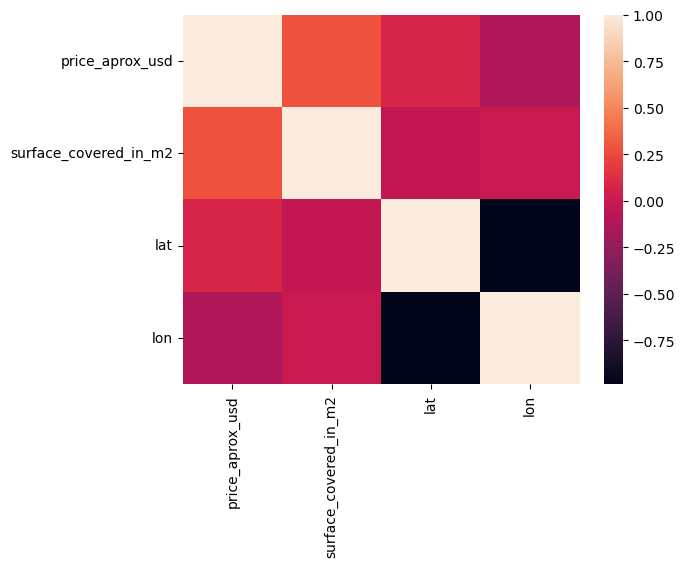

In [105]:
sns.heatmap(temp_df_6.select_dtypes("number").corr())

# Multicollinearity Cols
There appears to be no multicollinearity based on the variables left

In [107]:
temp_df_6.head()

price_aprox_usd  surface_covered_in_m2        lat        lon  \
1          82737.39                   75.0  19.362690 -99.150565   
3          72197.60                   62.0  19.291345 -99.124312   
4          44277.72                   85.0  19.354987 -99.061709   
13         60589.45                   52.0  19.469681 -99.086136   
18         47429.08                   53.0  19.443592 -99.121407   

                borough  
1         Benito Juárez  
3               Tlalpan  
4            Iztapalapa  
13    Gustavo A. Madero  
18  Venustiano Carranza

### Creating wrangle function to handle all wrangling and data cleaning done above. 
Since I will be importing multiple data files, the function seems like a clean way to manage and clean all data

In [108]:
def wrangle (file_path):
    df = pd.read_csv(file_path)
    # Mask to only "Distrito Federal"
    mask_DF = df["place_with_parent_names"].str.contains("Distrito Federal")
    # Mask to only apartment "property_type"
    mask_apt = df["property_type"]=="apartment"
    # Mask to only apartment "property_type"
    mask_100k = df["price_aprox_usd"] < 100000
    df = df[mask_DF & mask_apt & mask_100k]
    
    # Dealing with outliers
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_1_9 = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_1_9]
    
    # Create lat and lon column
    # df["lat-lon"].str.split(",", expand=True)[[0, 1]].head()
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True)[[0, 1]].astype(float)
    
    # Create borough column
    df["borough"] = df["place_with_parent_names"].str.split("|", expand=True)[1]

    # Dropping useless columsn
    df = df.drop(columns=["place_with_parent_names", "lat-lon"])
    
    # Dropping columsn with over half of its value being null
    # (temp_df_3.isnull().sum()/len(temp_df_3) >= 0.5).sum() ... 
    # 5 columns have over half miss values
    half_null_cols = ["surface_total_in_m2", "price_usd_per_m2", "floor", "rooms", 
                  "expenses"]
    df = df.drop(columns=half_null_cols)
    
    # Removing low and high cardinality cariables
    # df.select_dtypes("object").nunique()
    low_high_card_vars = ["operation", "property_type", "currency", "properati_url"]
    df = df.drop(columns = low_high_card_vars)
    
    # drop leakages columns
    leak_cols = ["price", "price_aprox_local_currency", "price_per_m2"]
    df = df.drop(columns=leak_cols)
    
    return df

In [110]:
# Gathering all files
from glob import glob
files = glob ("./data/mexico-city-real-estate-*.csv")
files

['./data\\mexico-city-real-estate-1.csv',
 './data\\mexico-city-real-estate-2.csv',
 './data\\mexico-city-real-estate-3.csv',
 './data\\mexico-city-real-estate-4.csv',
 './data\\mexico-city-real-estate-5.csv']

In [111]:
# Merging all data with list comprehension and pandas.concat
frames = [wrangle(file) for file in files]
df = pd.concat(frames)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 5473 entries, 11 to 4618
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             5473 non-null   int64  
 1   price_aprox_usd        5473 non-null   float64
 2   surface_covered_in_m2  5473 non-null   float64
 3   lat                    5149 non-null   float64
 4   lon                    5149 non-null   float64
 5   borough                5473 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 299.3+ KB


Unnamed: 0  price_aprox_usd  surface_covered_in_m2        lat         lon  \
11          12         94022.66                   57.0  23.634501 -102.552788   
20          21         70880.12                   56.0  19.402413  -99.095391   
21          22         68228.99                   80.0  19.357820  -99.149406   
22          23         24235.78                   60.0  19.504985  -99.208557   
26          27         94140.20                   50.0  19.354219  -99.126244   

          borough  
11  Benito Juárez  
20      Iztacalco  
21  Benito Juárez  
22   Azcapotzalco  
26       Coyoacán

### Descriptive Statistics / Data Exploration

Text(0.5, 1.0, 'Price DIstribution of Apartments greater less thn $100k in Distrito Federal')

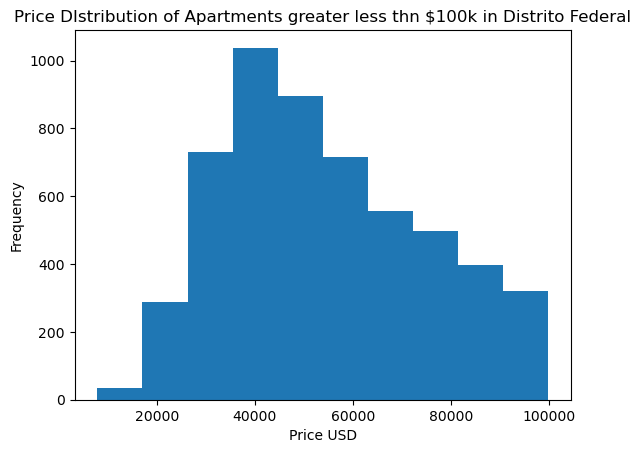

In [113]:
# Checking price distribution
plt.hist(df.price_aprox_usd)
plt.xlabel("Price USD")
plt.ylabel("Frequency")
plt.title("Price DIstribution of Apartments greater less thn $100k in Distrito Federal")

Text(0.5, 1.0, 'Surface Area [m2] Distribution')

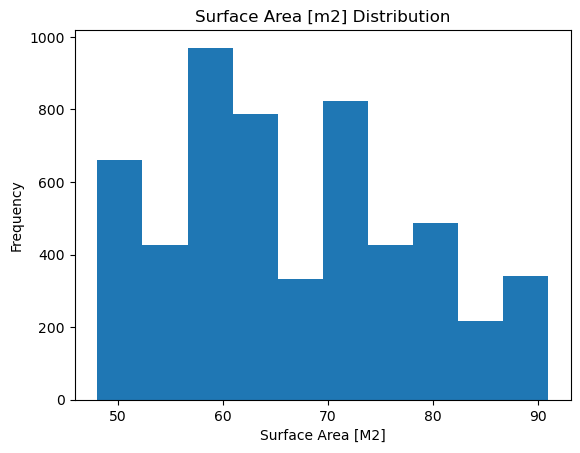

In [115]:
# Checking surface area distribution
plt.hist(df.surface_covered_in_m2)
plt.xlabel("Surface Area [M2]")
plt.ylabel("Frequency")
plt.title("Surface Area [m2] Distribution")

0.2763163303635239


Text(0.5, 1.0, 'Price USD vs Area M^2')

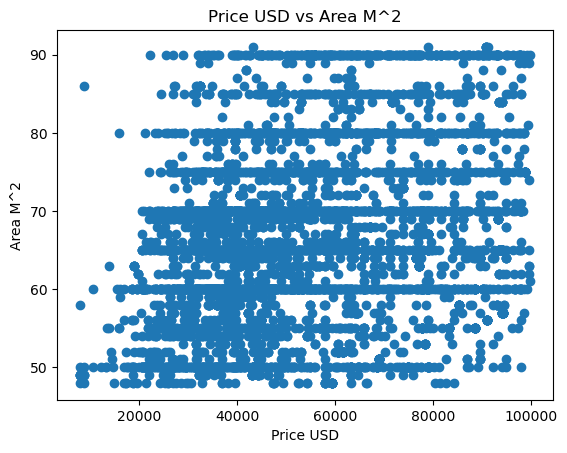

In [117]:
print(df.price_aprox_usd.corr(df.surface_covered_in_m2))
plt.scatter(x=df.price_aprox_usd, y=df.surface_covered_in_m2)
plt.xlabel("Price USD")
plt.ylabel("Area M^2")
plt.title("Price USD vs Area M^2")

There appears to be a weak positive correlation between prices and surface areas

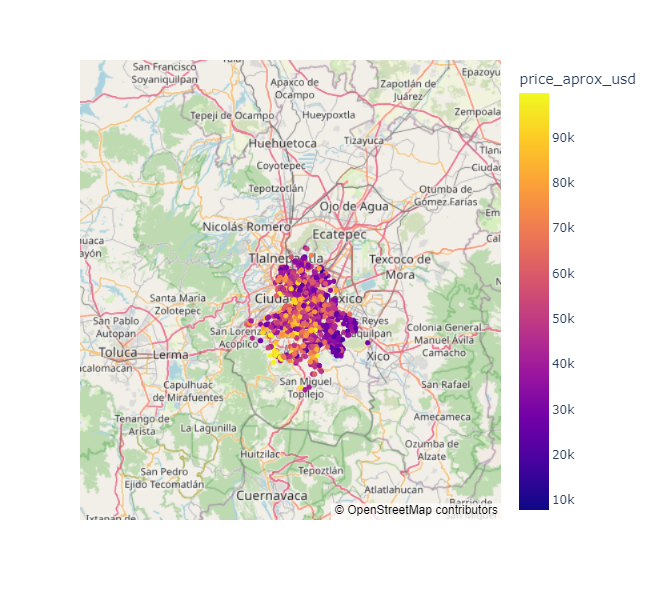

In [121]:
#### Trying out something cool. Ploting an interactive scatter map box
import plotly.express as px 
fig = px.scatter_mapbox(
    df,
    lat="lat",
    lon="lon",
    width=600,
    height=600,
    color="price_aprox_usd",
    hover_data=["price_aprox_usd"],
)

fig.update_layout(mapbox_style="open-street-map")

fig.show()

High proces seem to be distibuted more towards the south west and more concentrated in the cnetre of Mexico City